In [3]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# InAs model

n_exc = 3.14e23
n_eq = 1e23
alpha = 7
# depth = 7
# omega_exc = 44.5865 * np.sqrt(n_exc)
omega_eq = 20.7539 * np.sqrt(n_eq)
gamma_sec = 3.3e12

# omega_min_sec = np.sqrt(omega_eq**2 - gamma_sec**2 / 4)
# omega_max_sec = np.sqrt(omega_exc**2 + omega_eq**2 - gamma_sec**2 / 4)
# omega_z_sec = np.sqrt(omega_exc**2 + omega_eq**2 - gamma_sec**2 / 4)
# omega_min_sec = 1.18e13
# omega_max_sec = 6.35e12


csecmusmec = 3 * 10**14
Tstep_ps = (1e-6 / 3e8 * 1e12)
Tstep_factor = (1e-6 / 3e8)

# omega_max = omega_min_sec / csecmusmec
# omega_min = omega_max_sec / csecmusmec
gamma = gamma_sec / csecmusmec



# pd_current = lambda t: np.sin( 0.5 * (omega_max + omega_min) *  t) * np.sin( 0.5 * (omega_max - omega_min) *  t) * np.exp(-gamma * t/2) / t if t>0 else 0

def pd_current_depth_spot(yp,xp):
    sigma_x = 40 / (2 * np.sqrt(2 * np.log(2)))
    nexc = 3.14e23 * np.exp(-yp * alpha) * np.exp(-xp**2 / (2 * sigma_x**2))
    omega_exc = 44.5865 * np.sqrt(nexc)
    omega_z_sec = np.sqrt(omega_exc**2 + omega_eq**2 - gamma_sec**2 / 4)
    omega_z = omega_z_sec / csecmusmec
    t0_sec = 0.2e-12
    t0 = t0_sec / Tstep_factor
    return lambda t: nexc * np.sin(  omega_z *  (t-t0)) * np.exp(-gamma * (t-t0)/2) / omega_z if t>t0 else 0
    
def pd_current_depth(xp):
    omega_exc = 44.5865 * np.sqrt(n_exc * np.exp(-xp * alpha))
    omega_z_sec = np.sqrt(omega_exc**2 + omega_eq**2 - gamma_sec**2 / 4)
    omega_z = omega_z_sec / csecmusmec
    t0_sec = 0.2e-12
    t0 = t0_sec / Tstep_factor
    return lambda t: np.exp(-xp * alpha) * np.sin( omega_z *  (t-t0)) * np.exp(-gamma * (t-t0)/2) / omega_z if t>t0 else 0
    

(-5e+24, 5e+24)

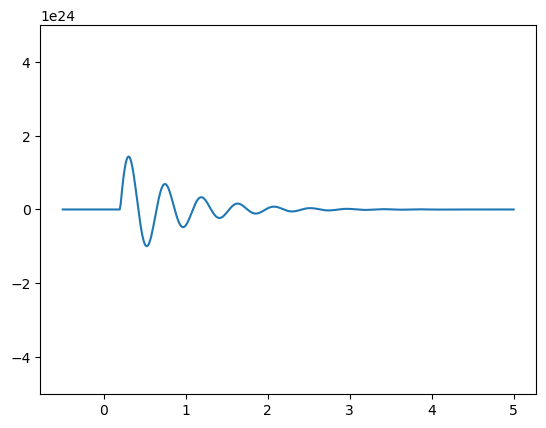

In [20]:
xp = 0
yp = 4 * alpha
tt = np.linspace(-0.5e-12/Tstep_factor,5e-12 / Tstep_factor,500)
current = list(map(pd_current_depth_spot(0,yp), tt))
plt.plot(tt * Tstep_factor * 1e12,current)
plt.ylim(-5e24,5e24)

     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


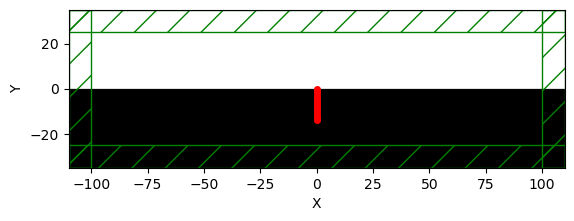

In [55]:
from itertools import chain

resolution = 10

sx = 200
sy = 50
dpml = 10

cell = mp.Vector3(sx + 2 * dpml, sy + 2 * dpml)

pml_layers = [mp.PML(dpml)]


depth = 0.5 * alpha
# sources = [
#     mp.Source(
#         src=mp.CustomSource(src_func=pd_current_depth(depth * 0)),
#         center=mp.Vector3(0,-depth * 0),
#         component=mp.Ey,
#     ),
#    mp.Source(
#         src=mp.CustomSource(src_func=pd_current_depth(depth * 0.5)),
#         center=mp.Vector3(0,-depth * 0.5),
#         component=mp.Ey,
#     ),
#     mp.Source(
#         src=mp.CustomSource(src_func=pd_current_depth(depth * 1)),
#         center=mp.Vector3(0,-depth * 1),
#         component=mp.Ey,
#     )
# ]

# sources = [
#     mp.Source(
#         src=mp.CustomSource(src_func=pd_current_depth(depth * ddx)),
#         center=mp.Vector3(0,-ddx),
#         component=mp.Ey,
#     ) for ddx in np.linspace(0, 2*alpha, num=10)
# ]

sources_mat = [
    [mp.Source(
        src=mp.CustomSource(src_func=pd_current_depth_spot(depth * yp, xp)),
        center=mp.Vector3(xp,-yp),
        component=mp.Ey,
    ) for yp in np.linspace(0, 2*alpha, num=15)] for xp in np.linspace(0,0,num=1)
]

# sources_mat = [
#     [mp.Source(
#         src=mp.CustomSource(src_func=pd_current_depth_spot(depth * yp, xp)),
#         center=mp.Vector3(xp,-yp),
#         component=mp.Ey,
#     ) for yp in np.linspace(0.5*alpha, 0.5*alpha, num=1)] for xp in np.linspace(0,0,num=1)
# ]
        

sources = list(chain.from_iterable(sources_mat))

geometry = [
    mp.Block(
        mp.Vector3(mp.inf, sy/2 + dpml, mp.inf),
        center=mp.Vector3(0,-sy/4 - dpml/2),
        material=mp.Medium(epsilon=12),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    symmetries=[mp.Mirror(mp.X)],
    progress_interval = 15
)



%matplotlib inline
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [56]:
distance_from_surface = 1 # \mu m
vals = []

def get_slice(sim):
    vals.append(sim.get_array(center=mp.Vector3(0,distance_from_surface),
                              size=mp.Vector3(sx,0), 
                              component=mp.Ex))

vals = []
sim.reset_meep()
sim.run(mp.at_every(10, get_slice),
        until=500)

-----------
Initializing structure...
Halving computational cell along direction x
time for choose_chunkdivision = 0.0023129 s
Working in 2D dimensions.
Computational cell is 220 x 70 x 0 with resolution 10
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.929812 s
-----------
on time step 704 (time=35.2), 0.00568187 s/step
on time step 1414 (time=70.7), 0.00563832 s/step
on time step 2133 (time=106.65), 0.00556513 s/step
Meep progress: 133.25/500.0 = 26.6% done in 15.0s, 41.3s to go
on time step 2848 (time=142.4), 0.00559963 s/step
on time step 3546 (time=177.3), 0.00573521 s/step
on time step 4237 (time=211.85), 0.00579079 s/step
on time step 4920 (time=246), 0.00586122 s/step
Meep progress: 263.0/500.0 = 52.6% done in 30.0s, 27.0s to go
on time step 5623 (time=281.15), 0.00569332 s/step
on time step 6290 (time=314.5), 0.00600694 s/step
on time 

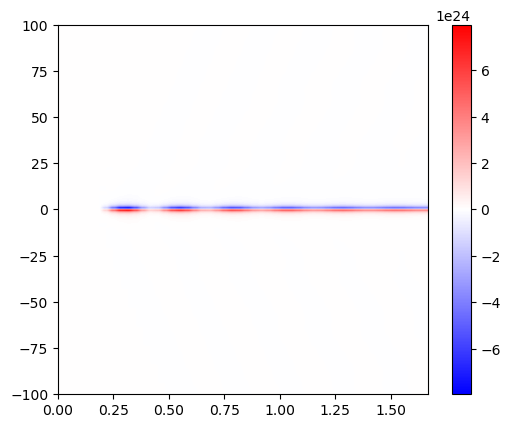

7.953374699944505e+24

In [57]:
plt.figure()
val_np = np.array(vals)
mm = np.max(val_np)
plt.imshow(val_np.T, 
           cmap='bwr',
           aspect = 500 * Tstep_ps / sx,
           extent = [0,500 * Tstep_ps,-sx/2,sx/2])
# plt.clim(vmin=-mm, vmax=mm)
plt.colorbar()
plt.show()

mm

In [58]:
(x,y,z,w)=sim.get_array_metadata(center=mp.Vector3(0,10), size=mp.Vector3(sx,0))
sigma = 20 / (np.sqrt(8 * np.log(2)))
xc = np.array(x)
intensity = np.exp(-(xc)**2/(2 * sigma**2))


def conv_line(field):
    padded_intensity = np.pad(intensity, (len(xc),len(xc)))
    padded_field = np.pad(field, (len(xc),len(xc)))
    conv_fi =  np.convolve(padded_intensity,padded_field,
                           mode='same')
    return conv_fi[len(xc):2 * len(xc) ]
    
# val_np2 = np.array([])
val_np2 = np.apply_along_axis(conv_line, 1, val_np)

(val_np.shape,val_np2.shape,xc.shape)

((50, 2002), (50, 2002), (2002,))

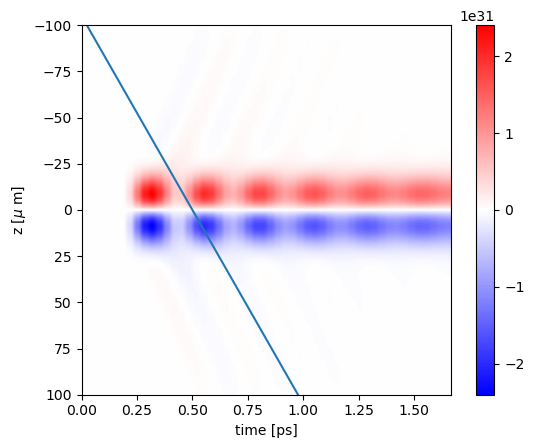

In [59]:
plt.imshow(val_np2.T * 1e6, cmap='bwr',
           aspect = 500 * Tstep_ps / sx,
           extent = [0,500 * Tstep_ps,-sx/2,sx/2])

ve_elec = 0.7 * 3 * 10**(8+6-12) # [\mu m / ps]
line_el = lambda t, deltat : ve_elec * (t - deltat)
t_el = np.arange(-2,10,.2)
z_el = line_el(t_el, 0.5)
plt.plot(t_el,z_el)
plt.xlim([0,500 * Tstep_ps])
plt.ylim([-sx/2,sx/2])
plt.gca().invert_yaxis()
plt.xlabel('time [ps]')
plt.ylabel('z [$\mu$ m]')
plt.colorbar()
plt.show()


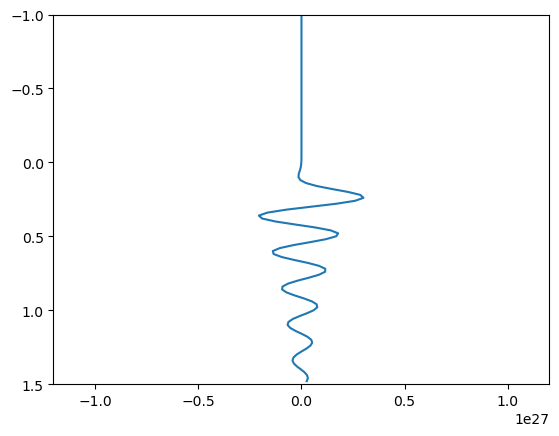

In [60]:
from scipy.interpolate import RegularGridInterpolator

t_vec = np.arange(Tstep_ps,500*Tstep_ps,10*Tstep_ps)
z_vec = np.array(x)

(z_vec.shape, val_np.shape)
interp = RegularGridInterpolator((t_vec, z_vec), val_np2,
                                 bounds_error=False,
                                 fill_value=0)


def field_along_electron(deltat):
    ddz = np.arange(-200,200,.5)
    return np.trapz(interp((ddz / ve_elec + deltat,ddz), method='slinear'),dx = 0.5)

delta_t = np.arange(-1,1.5,0.02)

eels = np.array(list(map(field_along_electron,delta_t)))

plt.plot(eels,delta_t)
plt.xlim(-4*max(eels),4*max(eels))
plt.ylim(-1,1.5)
plt.gca().invert_yaxis()